#  Influence of Acidic Properties on Red Wine Quality

## Introduction

Understanding the chemical properties that contribute to red wine quality has been an area of focus for years. For example, density, sulphate concentration, and alcohol content can vary between wines that relate to overall quality$^1$. Specifically, acids in wine contribute to sourness, astringency, and colour$^2$. Here, we ask if we can use wine acidity measurements to predict whether a wine is of good or bad quality. 

[Our dataset](https://archive.ics.uci.edu/ml/datasets/Wine+Quality) originally includes 11 chemical properties for various Portuguese wines, with the outcome variable being a categorical quality rating from 0 to 10. The data set contains several acidity measurements. Citric acid and fixed acidity are primarily measures of acidic components that originate from the grape used for wine-making, whereas the volatile acidity is mainly a byproduct of yeast and bacteria$^3$. The low pH of wine is maintained by the presence of these acids$^2$.


## Preliminary Data Analysis

In [50]:
# First we loaded the tidyverse, repr, tidymodels, and plyr packages
library(tidyverse)
library(repr)
library(tidymodels)
library(plyr)

We loaded the csv file for red wine data from the UCI website.

In [51]:
wine_data <- read_delim('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', delim = ";")
colnames(wine_data) <- make.names(colnames(wine_data)) # We replaced spaces in column titles with periods.
head(wine_data) # This displays the first 6 rows of our dataframe of 1599 rows.

Parsed with column specification:
cols(
  `fixed acidity` = col_double(),
  `volatile acidity` = col_double(),
  `citric acid` = col_double(),
  `residual sugar` = col_double(),
  chlorides = col_double(),
  `free sulfur dioxide` = col_double(),
  `total sulfur dioxide` = col_double(),
  density = col_double(),
  pH = col_double(),
  sulphates = col_double(),
  alcohol = col_double(),
  quality = col_double()
)



fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5


Then, we selected the predictor columns and the target variable needed for analysis. Afterwards, we converted *quality* from a numeric scale (0 to 10) to a binary factor (bad (from 0 to 5) and good (from 6 to 10)) to obtain two target classes.

In [52]:
wine_data_wrangled <- wine_data %>% 
    select(fixed.acidity, volatile.acidity, citric.acid, pH, quality) %>% 
    mutate(quality = revalue(as_factor(quality > 5), c('FALSE' = 'bad', 'TRUE' = 'good'))) 
    
head(wine_data_wrangled) # This displays the first 6 rows of our dataframe

fixed.acidity,volatile.acidity,citric.acid,pH,quality
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7.4,0.70,0.00,3.51,bad
7.8,0.88,0.00,3.20,bad
7.8,0.76,0.04,3.26,bad
11.2,0.28,0.56,3.16,good
7.4,0.70,0.00,3.51,bad
7.4,0.66,0.00,3.51,bad


Next, we split the data into training and testing sets.

In [53]:
set.seed(1)
wine_split <- initial_split(wine_data_wrangled, prop = 0.75, strata = quality) # We split 75% of data into the training set, and 25% into the testing set.
wine_train <- training(wine_split)
wine_test <- testing(wine_split)
glimpse(wine_train) # This displays a preview of our training set

Rows: 1,200
Columns: 5
$ fixed.acidity    <dbl> 7.8, 7.8, 11.2, 7.4, 7.4, 7.9, 7.3, 7.5, 6.7, 7.5, 5…
$ volatile.acidity <dbl> 0.880, 0.760, 0.280, 0.700, 0.660, 0.600, 0.650, 0.5…
$ citric.acid      <dbl> 0.00, 0.04, 0.56, 0.00, 0.00, 0.06, 0.00, 0.36, 0.08…
$ pH               <dbl> 3.20, 3.26, 3.16, 3.51, 3.51, 3.30, 3.39, 3.35, 3.28…
$ quality          <fct> bad, bad, good, bad, bad, bad, good, bad, bad, bad, …


The following cell contains a **data summary table**. It contains means of all predictors for each *quality* class, which could help predict relationships between acidity and quality. We also report the number of observations in each *quality* class.

In [54]:
# Note: only training set data is included in the data summary table.
wine_data_summarized <- wine_train %>% 
    group_by(quality) %>% 
    dplyr::summarise(mean.fixed.acidity = mean(fixed.acidity), 
                     mean.volatile.acidity = mean(volatile.acidity), 
                     mean.citric.acid = mean(citric.acid), 
                     mean.pH = mean(pH), 
                     num.obs = n())
wine_data_summarized

`summarise()` ungrouping output (override with `.groups` argument)



quality,mean.fixed.acidity,mean.volatile.acidity,mean.citric.acid,mean.pH,num.obs
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
bad,8.103943,0.5932975,0.2397670,3.315233,558
good,8.484735,0.4730919,0.3011994,3.310452,642


Finally, the next 4 cells contain **histograms** comparing distributions of each predictor for both *quality* types. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



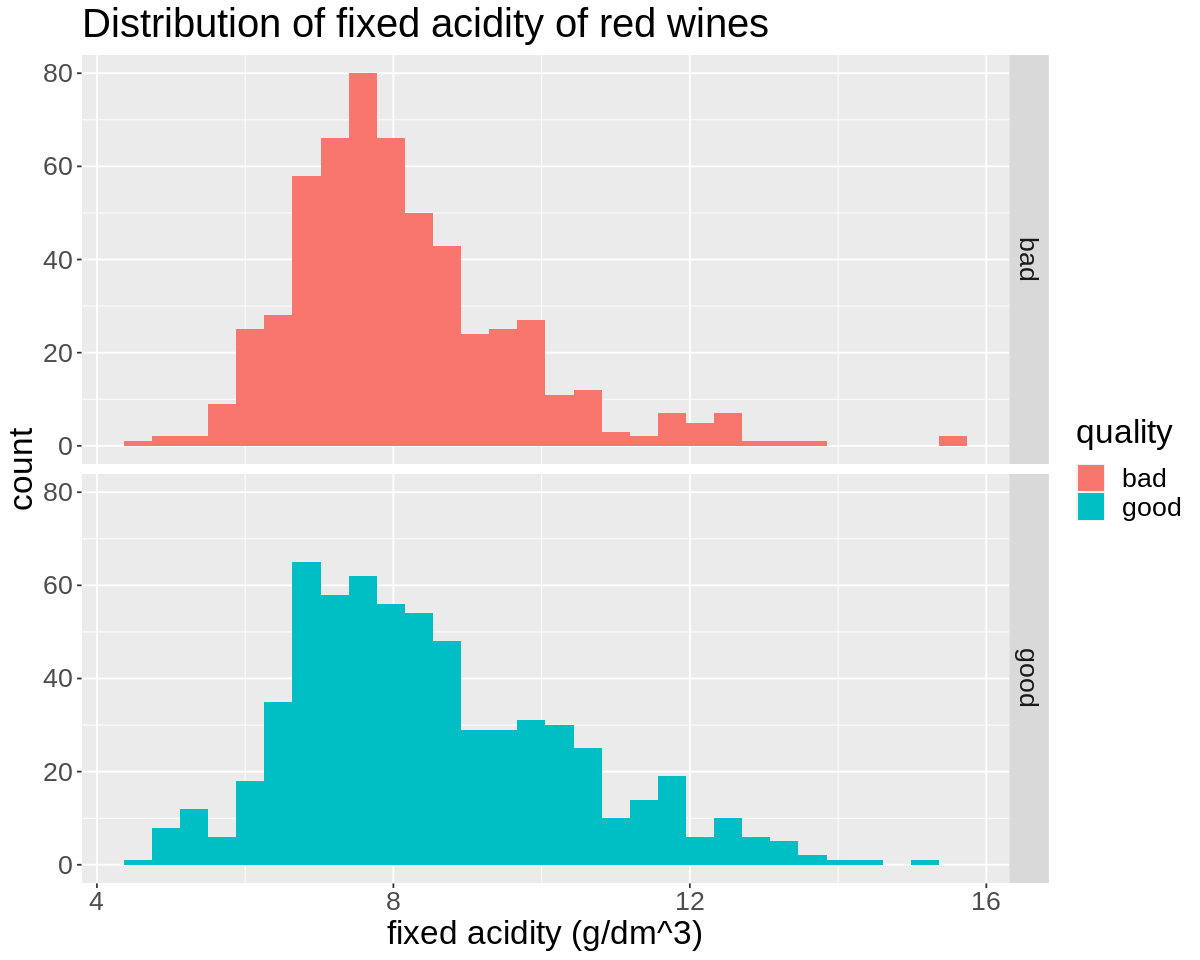

In [55]:
# Note: we used only training set data to create all of our histograms
options(repr.plot.width = 10, repr.plot.height = 8)
fixed_acidity_graph <- wine_train %>% 
    ggplot(aes(x = fixed.acidity, fill = quality)) +
        geom_histogram(position = 'identity') +
        xlab('fixed acidity (g/dm^3)') + 
        ggtitle('Distribution of fixed acidity of red wines') +
        facet_grid(quality ~ .) +
        theme(text = element_text(size = 20))
fixed_acidity_graph

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



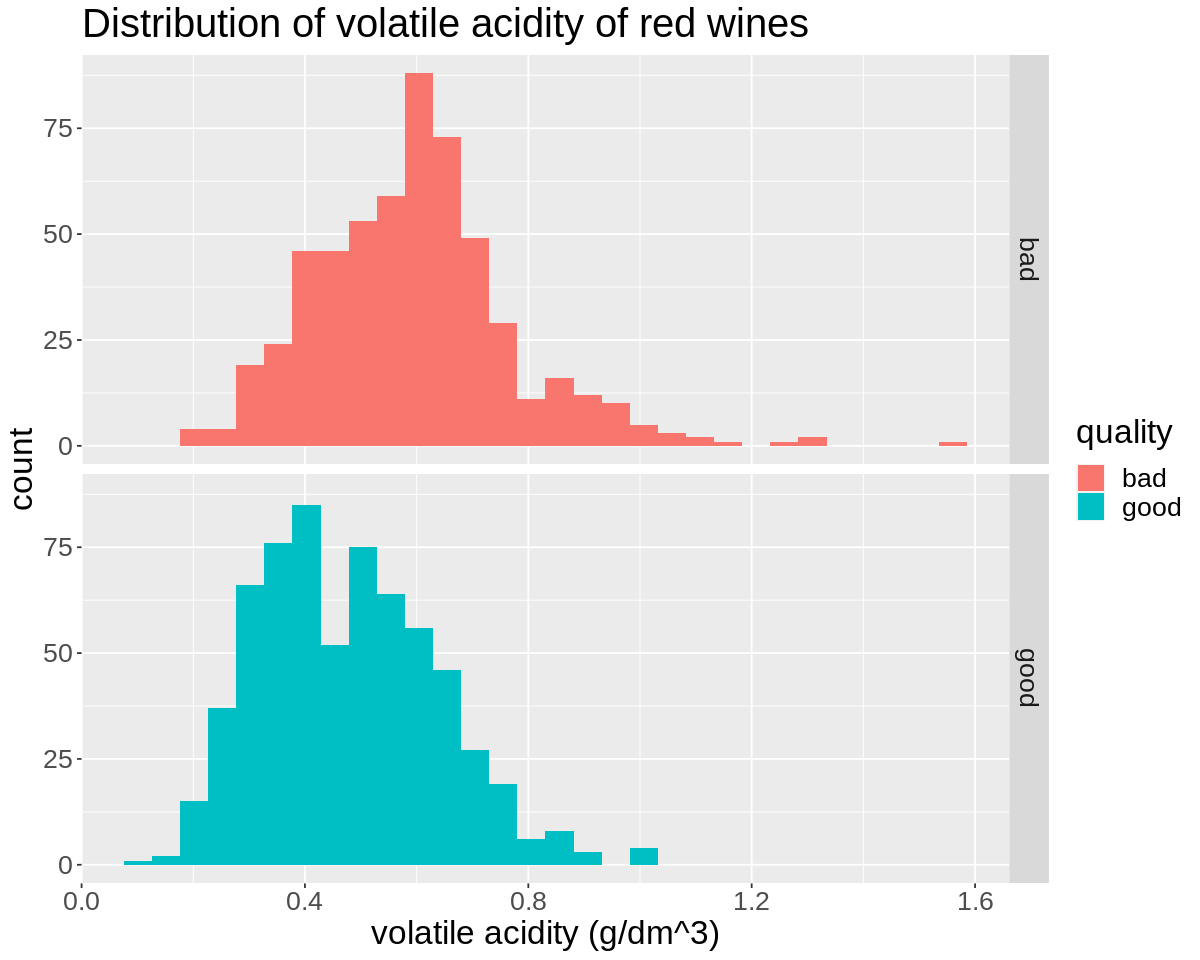

In [56]:
volatile_acidity_graph <- wine_train %>% 
    ggplot(aes(x = volatile.acidity, fill = quality)) +
        geom_histogram(position = 'identity') +
        xlab('volatile acidity (g/dm^3)') + 
        ggtitle('Distribution of volatile acidity of red wines') +
        facet_grid(quality ~ .) +
        theme(text = element_text(size = 20))
volatile_acidity_graph

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



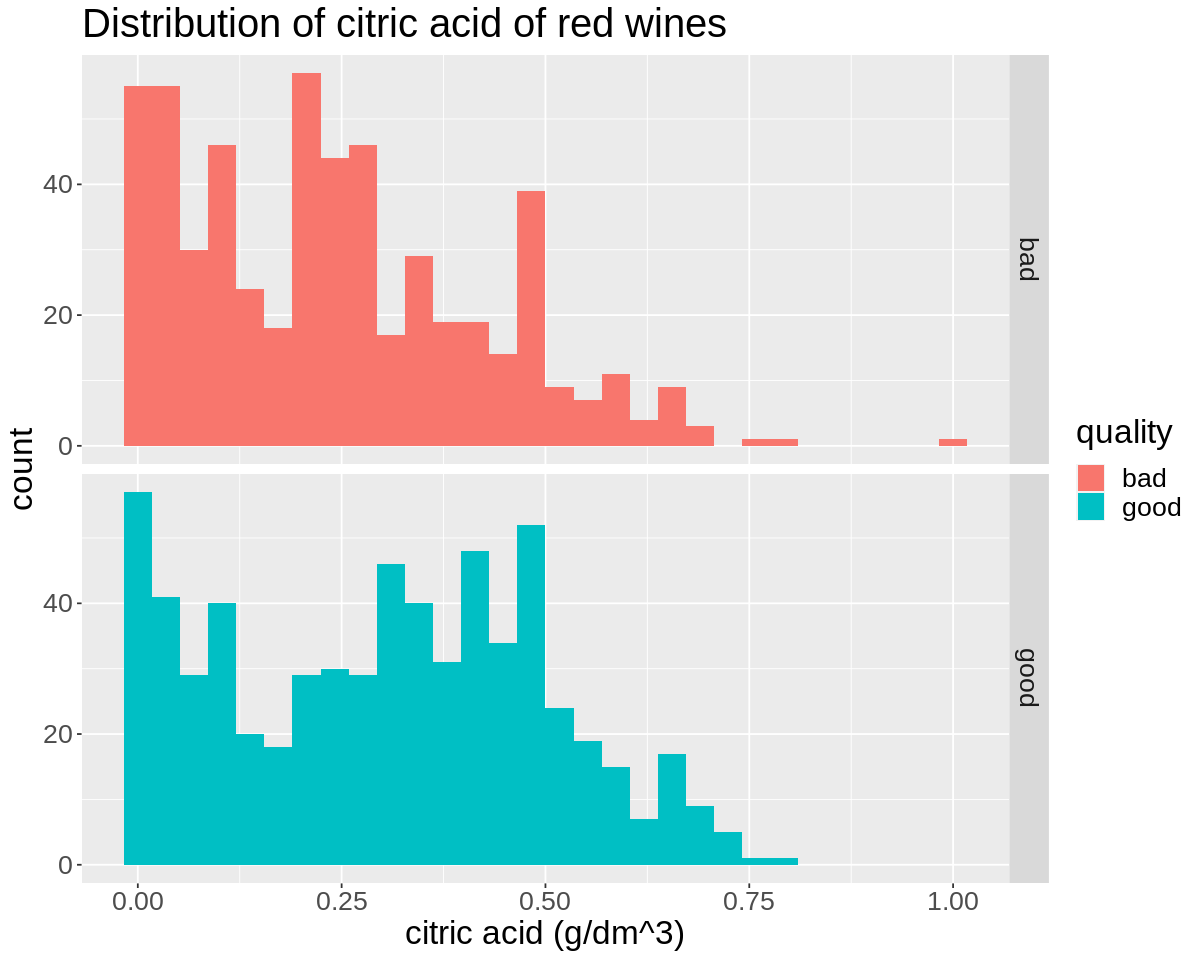

In [57]:
citric_acid_graph <- wine_train %>% 
    ggplot(aes(x = citric.acid, fill = quality)) +
        geom_histogram(position = 'identity') +
        xlab('citric acid (g/dm^3)') + 
        ggtitle('Distribution of citric acid of red wines') +
        facet_grid(quality ~ .) +
        theme(text = element_text(size = 20))
citric_acid_graph

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



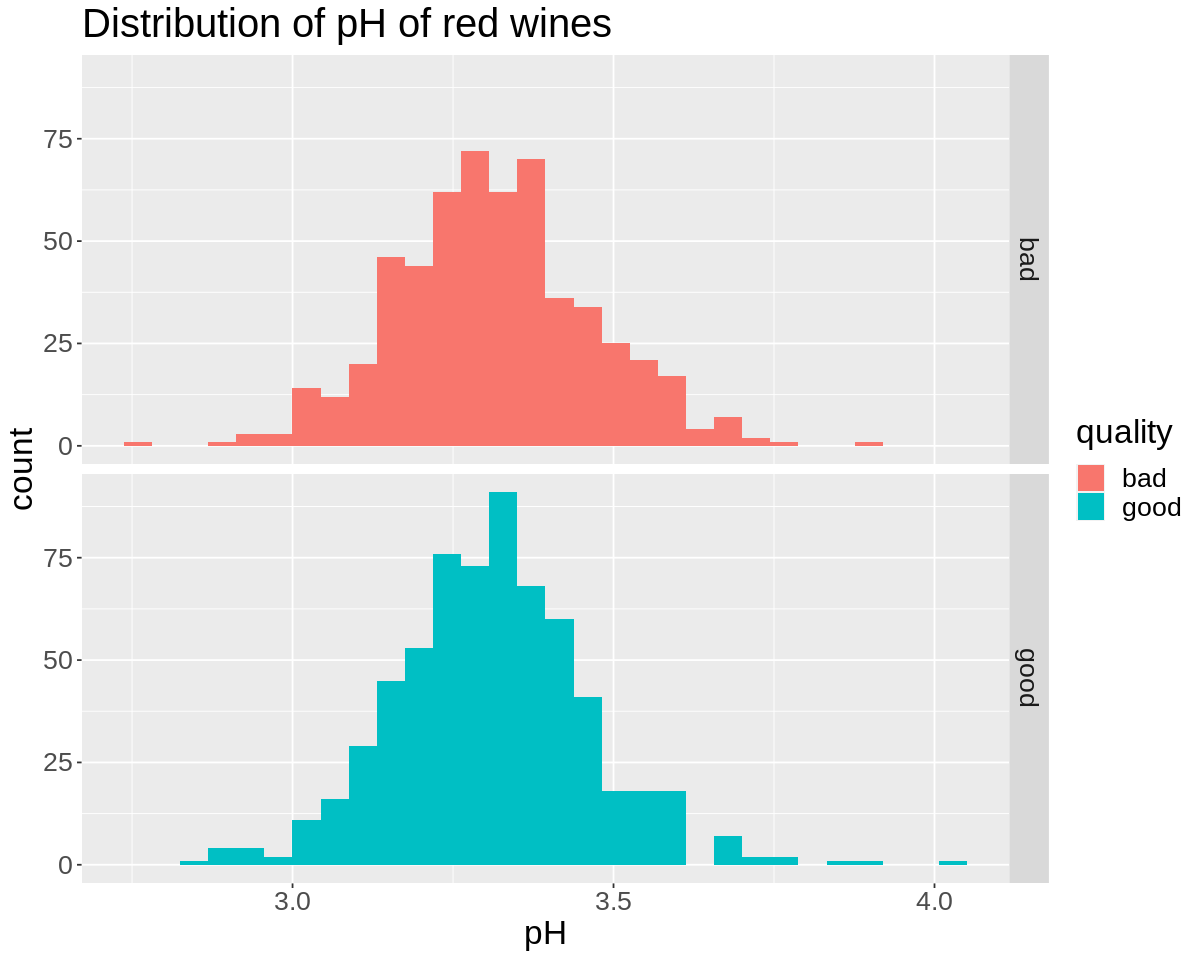

In [58]:
pH_graph <- wine_train %>% 
    ggplot(aes(x = pH, fill = quality)) +
        geom_histogram(position = 'identity') +
        xlab('pH') + 
        ggtitle('Distribution of pH of red wines') +
        facet_grid(quality ~ .) +
        theme(text = element_text(size = 20))
pH_graph

## Analysis

Prior to classification, we first identify the optimal number of neighbours to use for the K-nearest neighbors algorithm. We use 5-fold cross validation to assess 10 different neighbours using the training data.

In [59]:
set.seed(1)

wine_recipe <- recipe(quality ~ ., wine_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

wine_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

wine_vfold <- vfold_cv(wine_train, fold = 5, strata = quality)

wine_workflow <- workflow() %>%
    add_recipe(wine_recipe) %>%
    add_model(wine_spec)

gridvals <- tibble(neighbors = seq(1, 10))

wine_results <- wine_workflow %>%
    tune_grid(resamples = wine_vfold, grid = gridvals) %>%
    collect_metrics
head(wine_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6833454,10,0.010312392,Model01
1,roc_auc,binary,0.6812664,10,0.010425907,Model01
2,accuracy,binary,0.6833454,10,0.010312392,Model02
2,roc_auc,binary,0.6775485,10,0.009648272,Model02
3,accuracy,binary,0.6241843,10,0.009728303,Model03
3,roc_auc,binary,0.6687337,10,0.009461667,Model03


The accuracy estimates for each neighbour are extracted from the results and plotted on an Accuracy Estimate versus Neighbours plot.

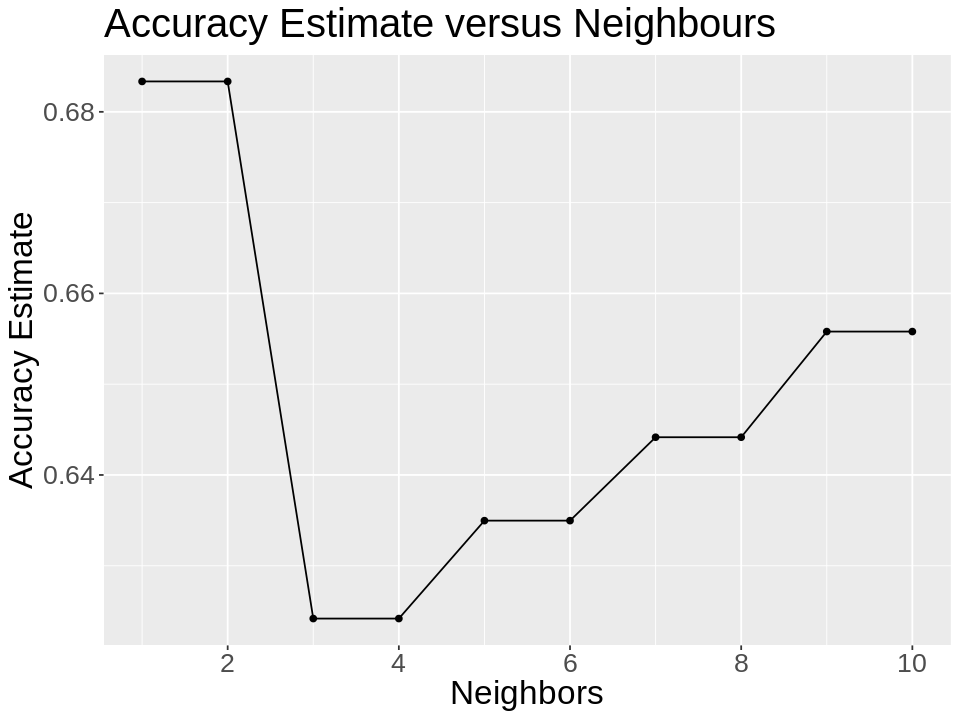

In [60]:
accuracies <- wine_results %>%
    filter(.metric == "accuracy")

options(repr.plot.width = 8, repr.plot.height = 6)
accuracy_vs_k <- accuracies %>%
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracy Estimate versus Neighbours") +
    theme(text=element_text(size=20)) +
    scale_x_continuous(breaks = seq(0, 10, by = 2))
accuracy_vs_k

In [61]:
wine_final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) %>%
    set_engine("kknn") %>%
    set_mode("classification")

wine_fit <- workflow() %>%
    add_recipe(wine_recipe) %>%
    add_model(wine_final_spec) %>% 
    fit(data = wine_train)

wine_predictions <- predict(wine_fit, wine_test) %>% 
    bind_cols(wine_test)

wine_prediction_accuracy <- wine_predictions %>% 
    metrics(truth = quality, estimate = .pred_class)

head(wine_predictions)
wine_prediction_accuracy

.pred_class,fixed.acidity,volatile.acidity,citric.acid,pH,quality
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
bad,7.4,0.70,0.00,3.51,bad
good,7.8,0.58,0.02,3.36,good
good,7.9,0.32,0.51,3.04,good
good,7.6,0.39,0.31,3.52,bad
bad,6.3,0.39,0.16,3.34,bad
bad,7.1,0.71,0.00,3.47,bad


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6541353
kap,binary,0.3041401


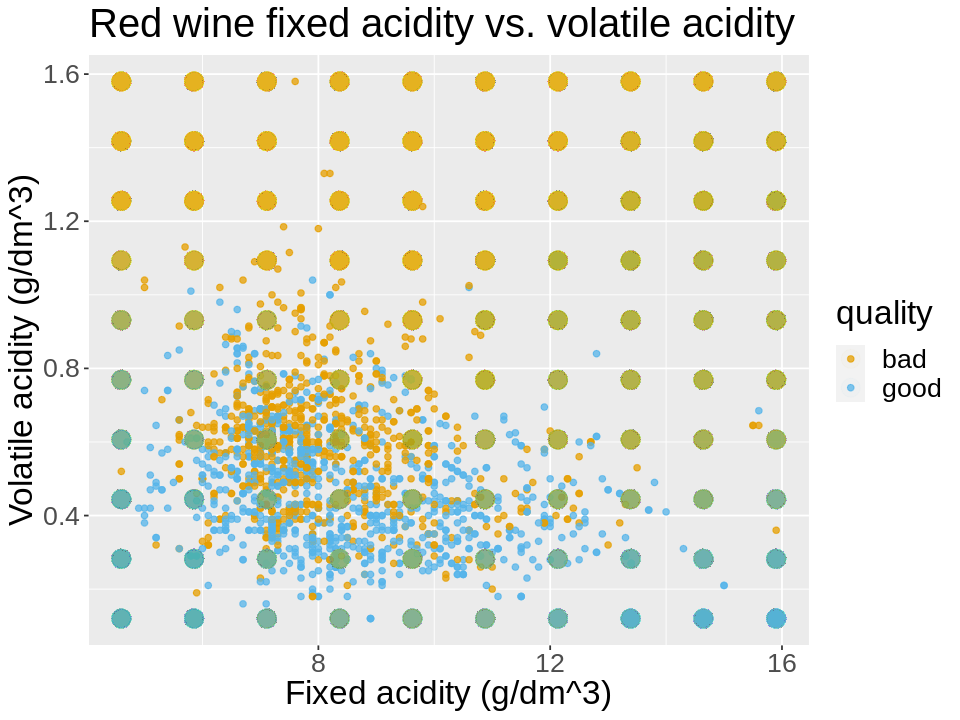

In [63]:
# wine_plot <- wine_predictions %>% 
#     ggplot(aes(x = fixed.acidity, y = volatile.acidity, colour = quality)) +
#         geom_point() +
#         labs(x = 'Fixed acidity (g/dm^3)', y = 'Volatile acidity (g/dm^3)') +
#         ggtitle('Red wine fixed acidity vs. volatile acidity') +
#         theme(text = element_text(size = 20))

# create the grid of fixed acidity/volatile acidity vals, and arrange in a data frame
are_grid <- seq(min(wine_data_wrangled$fixed.acidity), max(wine_data_wrangled$fixed.acidity), length.out = 10)
smo_grid <- seq(min(wine_data_wrangled$volatile.acidity), max(wine_data_wrangled$volatile.acidity), length.out = 10)
is_grid <- seq(min(wine_data_wrangled$citric.acid), max(wine_data_wrangled$citric.acid), length.out = 10)
small_grid <- seq(min(wine_data_wrangled$pH), max(wine_data_wrangled$pH), length.out = 10)
asgrid <- as_tibble(expand.grid(fixed.acidity = are_grid, 
                                volatile.acidity = smo_grid, 
                                citric.acid = is_grid, 
                                pH = small_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(wine_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) %>% select(.pred_class, fixed.acidity, volatile.acidity)

cbPalette <- c("#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#999999")

# plot:
# 1. the coloured scatter of the original data
# 2. the faded coloured scatter for the grid points
wine_plot <- ggplot() +
    geom_point(data = wine_data_wrangled, mapping = aes(x = fixed.acidity, y = volatile.acidity, color = quality), alpha = 0.75) +
    geom_point(data = prediction_table, mapping = aes(x = fixed.acidity, y = volatile.acidity, color = .pred_class), alpha = 0.02, size = 5.) +
    labs(x = 'Fixed acidity (g/dm^3)', y = 'Volatile acidity (g/dm^3)') +
    ggtitle('Red wine fixed acidity vs. volatile acidity') +
    theme(text = element_text(size = 20)) +
    scale_color_manual(values = cbPalette)

wine_plot

## Methods

We have selected only the variables related to acidity to predict wine quality: fixed acidity (g(tartaric acid)/dm$^3$), volatile acidity (g(acetic acid)/dm$^3$), citric acid (g/dm$^3$), and pH. We intend to use these variables as predictors in a K-nearest neighbours classification algorithm to classify wines as “bad quality” or “good quality”.

We’ll visualize our data using a combination of two scatter plots where the fixed and volatile acidity are on the x and y axis, respectively, and colored by quality using the colours yellow and blue. The background colour of the graph will indicate the decision of the classifier and the actual points will be the original data.


## Expected outcomes and significance

We expect to find that the acidic properties will predict wine quality. The impact of these findings could inform wine-makers on the ideal acidity level for quality, allowing them to use chemical testing to inform decisions made during wine-making. In predicting which wines will perform the best in market sales or competitions, understanding the relationship between acidity and quality would be important.

Our question can inform other questions such as: Do certain countries have a preference for a certain acidity of wine? Is there an ideal ratio between acidic compounds and other flavour compounds? Can this analysis also be done with white wines?


## References

$^1$Cortez, Paulo, et al. "Modeling Wine Preferences by Data Mining from Physicochemical Properties." Decision Support Systems, vol. 47, no. 4, 2009, pp. 547-553.

$^2$Jackson, Ronald S. “6 - Chemical Constituents of Grapes and Wine”. Elsevier Inc, 2014.

$^3$Jackson, Ronald S. “Chapter 6 - Qualitative Wine Assessment”. Elsevier Ltd, 2017.
